In [5]:
import sys
sys.path.append(r'C:\Users\akshay.raghuraman\Desktop\NIRFASTerFF\nirfaster-FF-main')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [6]:
# create a volume, make sure it's in uint8
vol = 2 * np.ones((60,60,60))
#vol[:,:,:15] = 1 # different regions labeled in different integers
vol = vol.astype(np.uint8)

In [7]:
#  def __init__(self, 
#               xPixelSpacing=1., 
#               yPixelSpacing=1.,
#               SliceThickness=1.,
#             facet_angle = 25., 
#             facet_size = 3., 
#             facet_distance = 2.,
#           cell_radius_edge = 3., 
#           general_cell_size = 3., 
#           subdomain = np.array([0., 0.]),
#          lloyd_smooth = True, offset = None):

In [8]:

#meshing_params = ff.utils.MeshingParams(0.01, 0.01, 0.01)

meshing_params = ff.utils.MeshingParams(
    xPixelSpacing=0.5,  # Finer voxel resolution
    yPixelSpacing=0.5,
    SliceThickness=0.5,
    general_cell_size=1.0,  # Smaller elements
    cell_radius_edge=2.0,  # Better element quality
    facet_size=1.5,  # More refined surface
    facet_distance=1.0
)


# call the mesher
ele, nodes = ff.meshing.RunCGALMeshGenerator(vol, opt = meshing_params)

# run the quality check
# ff.meshing.CheckMesh3D(ele, nodes)

In [9]:
mesh = ff.base.stndmesh()
mesh.from_solid(ele, nodes)

# have a look
# ff.visualize.plot3dmesh(mesh, mesh.region, '(z<20)&(x>30)')

In [10]:
# optical properties, similar to the MCX format
# for each row, [region, mua(mm-1), musp(mm-1), ri]
prop = np.array([[1, 0.01, 0.330033, 1.33]])
mesh.set_prop(prop)
# set link (source-detector pairs)
mesh.link = np.atleast_2d([1,1,1]) # make sure it's a n x 3 matrix
# optodes
mesh.source = ff.base.optode(np.array([10,30,57]))
mesh.meas = ff.base.optode(np.array([50,30,57]))
# move them (for non-fixed) and calculate the integration function
mesh.touch_optodes()

touching sources
touching detectors


In [11]:
xgrid = np.arange(0., 60, 0.5)
ygrid = np.arange(0., 60, 0.5)
zgrid = np.arange(0., 60, 0.5)

# xgrid = np.around(np.linspace(min(mesh.nodes[:,0]), max(mesh.nodes[:,0]), num=120),decimals=8)
# ygrid = np.around(np.linspace(min(mesh.nodes[:,1]), max(mesh.nodes[:,1]), num=100),decimals=8)
# zgrid = np.around(np.linspace(min(mesh.nodes[:,2]), max(mesh.nodes[:,2]), num=100),decimals=8)


mesh.gen_intmat(xgrid, ygrid, zgrid)

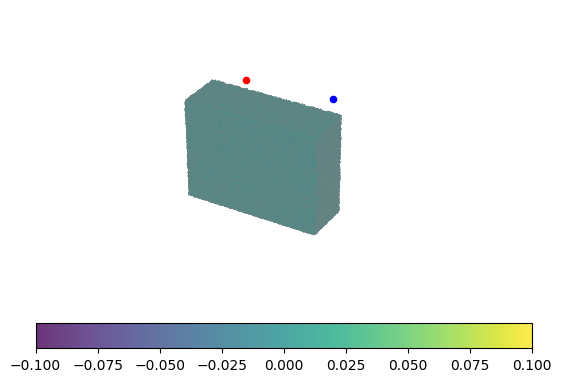

In [12]:
fig, ax = ff.visualize.plot3dmesh(mesh,selector='(y<20)')
ax.scatter(mesh.source.coord[:,0], mesh.source.coord[:,1], mesh.source.coord[:,2], color='r')
ax.scatter(mesh.meas.coord[:,0], mesh.meas.coord[:,1], mesh.meas.coord[:,2], color='b')
plt.show()


# print(mesh.source.coord)
# print(mesh.meas.coord)
# print(mesh.c)
# print(mesh.link)
# print(mesh.nodes.shape)
# print(mesh.nodes)

In [13]:
# DC jacobian at tau=0

J0,data0,_=ff.inverse.jacobian_stnd_CW(mesh, normalize=0)

Calculating direct field...
Calculating adjoint field...
Integrating...


C:\Users\akshay.raghuraman\Desktop\NIRFASTerFF\nirfaster-FF-main\nirfasterff\math.py:759: RuntimeWarning: invalid value encountered in divide
  int_func_tmp /= int_func_tmp.sum()


In [14]:
# Calulations for Jacobian at tau = T/2

tau = 0.5*(5e-7)
wv = 785 #nm
k0 = 2*np.pi / (wv/1e6)

#Define US parameters
va = 1480*1e3   # acoustic wave velocity
ka = 2*np.pi / (va/(2e6))  # va=1480m/s , fa=2Mhz
wa = 2*np.pi*2e6   # 2*pi*fa
ltr = 1/mesh.mus
rho = 1000*1e-9   # for water
eta = 0.32       # for water
Sa = 1.
phi = 0.

# Define UltraSound position
x_cen,y_cen,z_cen = [30,30,40]      #centre of the US
dist = np.sqrt(np.square((mesh.nodes[:,0]-x_cen)) + np.square((mesh.nodes[:,1]-y_cen)) + np.square((mesh.nodes[:,2]-z_cen)))
height = 5  #height of cylinder
dia = 4     #diameter of cylinder
ind= np.zeros(len(mesh.nodes))

for i in range(len(mesh.nodes)):     # selecting nodes for Cylindrical US: Z-axis aligned   
    if mesh.nodes[i,2]>(z_cen-height/2) and mesh.nodes[i,2]<(z_cen+height/2) and np.sqrt((mesh.nodes[i,0]-x_cen)**2+(mesh.nodes[i,1]-y_cen)**2) < dia/2 :
        ind[i] = dist[i] 

selection = np.argwhere(ind != 0)
p0 = np.zeros(len(mesh.mua))
p0[selection] = 1000           #assigning a pressure value to the selected nodes within the cylindrical vol

ht = (np.square((p0*k0*mesh.ri)/(ka*rho*va*va))) * (1-np.cos(wa*tau)) * ( (np.square(eta))*(ka*ltr)*(np.arctan(ka*ltr)) + Sa*Sa/3 - 2*eta*Sa/np.cos(phi) )


In [15]:
#Defining a spehrical added absorber
#This is implemented in the "line scan" program fpr faster processing.


# dia_ab = 6    #diameter of spherical absorber
# x_cen_ab,y_cen_ab,z_cen_ab = [10,30,40]      #centre of the absorber
# dist_ab = np.sqrt(np.square((mesh.nodes[:,0]-x_cen_ab)) + np.square((mesh.nodes[:,1]-y_cen_ab)) + np.square((mesh.nodes[:,2]-z_cen_ab)))
# ind_ab = dist_ab < dia_ab/2
# mua_selection = np.where(ind_ab)
# mesh.mua[mua_selection] = 0.02
#print(mua_selection)

In [16]:
meshT = ff.base.stndmesh()
meshT.from_copy(mesh)
meshT.mua = mesh.mua + meshT.mus*ht
meshT.kappa = 1/(3*(meshT.mua + meshT.mus))

JT, dataT, _ = ff.inverse.jacobian_stnd_CW(meshT, normalize=0)


Calculating direct field...
Calculating adjoint field...
Integrating...


In [17]:
# dc and ac data
y_dc = data0.amplitude
y_ac = y_dc - dataT.amplitude

# J_ac and J_md
J_ac = J0 - JT
# It should be J_AC, not J(T/2)! There's an error in the paper
J_md = (J_ac*y_dc[:,None] - J0*y_ac[:,None])/y_dc[:,None]**2

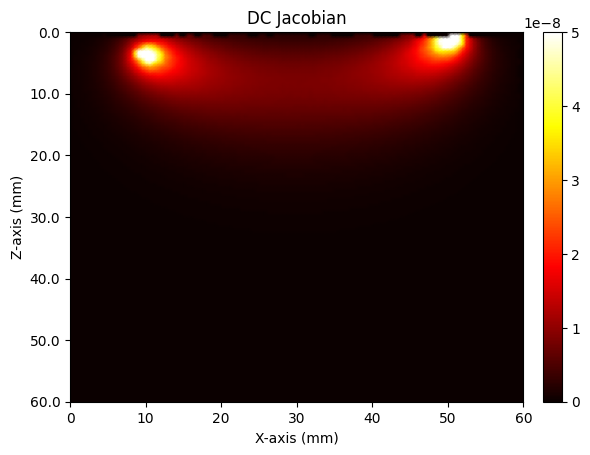

In [18]:
# plot the DC banana
banana1 = J0.reshape((xgrid.size, ygrid.size, zgrid.size), order='f') 



#plot with imshow
# plt.set_cmap('hot')
# h = plt.imshow(-banana1[60,:,:].T, origin='lower',vmin=0,vmax=1e-7,extent = [0, 60, 0, 60])




#Plot using `pcolormesh` for smooth shading
X, Z = np.meshgrid(np.linspace(0, 60, banana1.shape[1]),  
                   np.linspace(0, 60, banana1.shape[2]))

cmap = plt.get_cmap('hot')  
norm = mcolors.Normalize(vmin=0, vmax=0.5e-7)  
h = plt.pcolormesh(X, Z, -banana1[60, :, :].T, cmap=cmap, norm=norm, shading='gouraud')

plt.colorbar(h, fraction=0.046, pad=0.04)


yticks = plt.gca().get_yticks()  # Get the original tick positions
plt.gca().set_yticks(yticks)  # Set them back
plt.gca().set_yticklabels(yticks[::-1])


plt.xlabel("X-axis (mm)")
plt.ylabel("Z-axis (mm)")
plt.title("DC Jacobian")
plt.show()

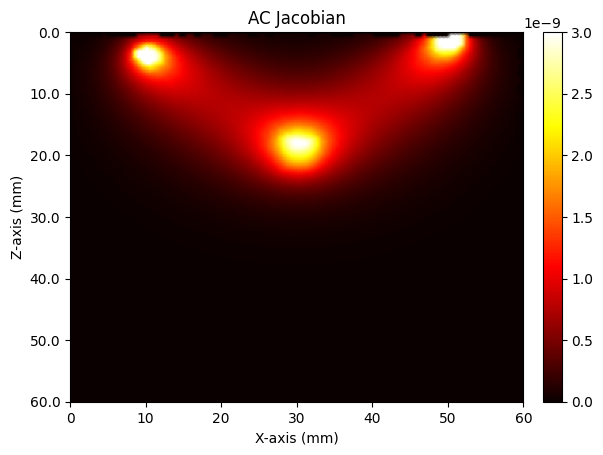

In [19]:
banana_ac = J_ac.reshape((xgrid.size, ygrid.size, zgrid.size), order='f') 

#plot with imshow
# plt.set_cmap('hot')
# h = plt.imshow(-banana_ac[30,:,:].T, origin='lower',vmin=0,vmax=1e-8)


# Plot using `pcolormesh` for smooth shading
X, Z = np.meshgrid(np.linspace(0, 60, banana_ac.shape[1]),  
                   np.linspace(0, 60, banana_ac.shape[2]))

cmap = plt.get_cmap('hot')  
norm = mcolors.Normalize(vmin=0, vmax=0.3e-8)  
h = plt.pcolormesh(X, Z, -banana_ac[60, :, :].T, cmap=cmap, norm=norm, shading='gouraud')
plt.colorbar(h, fraction=0.046, pad=0.04)


#Invert z axis
yticks = plt.gca().get_yticks()  # Get the original tick positions
plt.gca().set_yticks(yticks)  # Set them back
plt.gca().set_yticklabels(yticks[::-1])


plt.xlabel("X-axis (mm)")
plt.ylabel("Z-axis (mm)")
plt.title("AC Jacobian")


plt.show()

In [20]:
# banana_md = J_md.reshape((xgrid.size, ygrid.size, zgrid.size), order='f') 
# plt.set_cmap('hot')


# h = plt.imshow(-banana_md[60,:,:].T, origin='lower')
# # plt.xlim(0, 60) 
# # plt.ylim(0, 60)
# plt.colorbar(h, fraction=0.046, pad=0.04)



# plt.show()

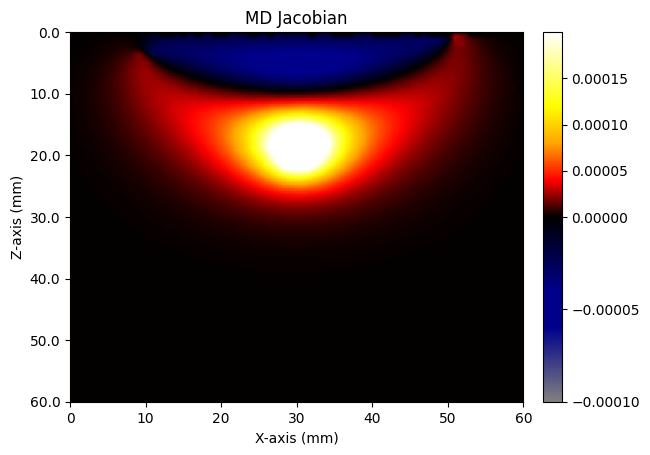

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Reshape J_md to match the grid size
banana_md = J_md.reshape((xgrid.size, ygrid.size, zgrid.size), order='f')


norm = mcolors.TwoSlopeNorm(vmin=-0.1e-3, vcenter=0, vmax=0.2e-3)

# Create a custom colormap
cmap_colors = [
    (0, "grey"),  
    (0.2, "darkblue"),
    (0.3, "darkblue"),
    (0.5, "black"),     
    (0.6, "red"),    
    (0.7, "orange"),      
    (0.8, "yellow"),
    (1.0, "white")     
]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot_blue", cmap_colors, N=500)


# Plot using imshow
#h = plt.imshow(-banana_md[30, :, :].T, origin='lower', cmap=custom_cmap, norm=norm,extent = [0, 60, 0, 60])


# Plot using `pcolormesh` for smooth shading
X, Z = np.meshgrid(np.linspace(0, 60, banana1.shape[1]),  
                   np.linspace(0, 60, banana1.shape[2]))
h = plt.pcolormesh(X, Z, -banana_md[60, :, :].T, cmap=custom_cmap, norm=norm, shading='gouraud')

# Add colorbar
plt.colorbar(h, fraction=0.046, pad=0.04)


#Invert z axis
yticks = plt.gca().get_yticks()  # Get the original tick positions
plt.gca().set_yticks(yticks)  # Set them back
plt.gca().set_yticklabels(yticks[::-1])



# Show plot
plt.xlabel("X-axis (mm)")
plt.ylabel("Z-axis (mm)")
plt.title("MD Jacobian")
plt.show()


In [22]:

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# # Reshape J_md to match the grid size
# banana_md = J_md.reshape((xgrid.size, ygrid.size, zgrid.size), order='f')

# # Define min and max values
# vmin = banana_md.min()  # Most negative value
# vmax = banana_md.max()  # Most positive value

# # Define a custom normalization where:
# # - Zero is black
# # - Negative values fade from black to blue
# # - Positive values follow the 'hot' colormap
# norm = mcolors.TwoSlopeNorm(vmin=-0.25e-4, vcenter=0, vmax=0.0001)

# # Create a custom colormap
# cmap_colors = [
#     (0.0, "purple"),  
#     (0.05, "darkviolet"),
#     (0.3, "darkblue"),
#     (0.4, "black"),     
#     (0.5, "black"),     
#     (0.6, "red"),     
#     (0.7, "orange"),       
#     (0.8, "yellow"),
#     (1.0, "white") 
# ]
# custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot_blue", cmap_colors, N=500)


# # Plot using imshow
# #h = plt.imshow(-banana_md[30, :, :].T, origin='lower', cmap=custom_cmap, norm=norm,extent = [0, 60, 0, 60])


# # Plot using `pcolormesh` for smooth shading
# X, Z = np.meshgrid(np.linspace(0, 60, banana1.shape[1]),  
#                    np.linspace(0, 60, banana1.shape[2]))
# h = plt.pcolormesh(X, Z, -banana_md[60, :, :].T, cmap=custom_cmap, norm=norm, shading='gouraud')




# # Add colorbar
# plt.colorbar(h, fraction=0.046, pad=0.04)

# # Show plot
# plt.xlabel("X-axis (mm)")
# plt.ylabel("Z-axis (mm)")

# plt.show()
